In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/har-test-dataset/Test_Videos/sitting22.mp4
/kaggle/input/har-test-dataset/Test_Videos/sitting6.mp4
/kaggle/input/har-test-dataset/Test_Videos/walking2.mp4
/kaggle/input/har-test-dataset/Test_Videos/sitting10.mp4
/kaggle/input/har-test-dataset/Test_Videos/standing28.mp4
/kaggle/input/har-test-dataset/Test_Videos/standing20.mp4
/kaggle/input/har-test-dataset/Test_Videos/standing5.mp4
/kaggle/input/har-test-dataset/Test_Videos/standing9.mp4
/kaggle/input/har-test-dataset/Test_Videos/sitting25.mp4
/kaggle/input/har-test-dataset/Test_Videos/standing25.mp4
/kaggle/input/har-test-dataset/Test_Videos/walking27.mp4
/kaggle/input/har-test-dataset/Test_Videos/sitting26.mp4
/kaggle/input/har-test-dataset/Test_Videos/walking3.mp4
/kaggle/input/har-test-dataset/Test_Videos/standing6.mp4
/kaggle/input/har-test-dataset/Test_Videos/walking19.mp4
/kaggle/input/har-test-dataset/Test_Videos/standing13.mp4
/kaggle/input/har-test-dataset/Test_Videos/standing18.mp4
/kaggle/input/har-test-datase

# Vision Transformer Model

## Importing Libraries

In [16]:
import torch
import pandas as pd
import cv2
import timm
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import timm
import torch.nn as nn

## Loading classes from training file

In [17]:
class ViTActivityClassifier(nn.Module):
    def __init__(self, num_classes=3, vit_name='vit_base_patch16_224'):
        super().__init__()
        self.vit = timm.create_model(vit_name, pretrained=False)
        self.vit.head = nn.Identity() 

        self.temporal_pooling = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(self.vit.num_features, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.vit(x)  # (B*T, feat_dim)
        feats = feats.view(B, T, -1).transpose(1, 2)  # (B, feat_dim, T)
        pooled = self.temporal_pooling(feats).squeeze(2)  # (B, feat_dim)
        out = self.classifier(pooled)  # (B, num_classes)
        return out

In [18]:
class VideoClipDataset(Dataset):
    def __init__(self, video_paths, num_frames=100, image_size=224):
        self.video_paths = video_paths
        self.num_frames = num_frames
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),  # (C, H, W)
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.video_paths)

    def read_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        idxs = np.linspace(0, total - 1, self.num_frames).astype(int)

        frames = []
        for i in range(total):
            ret, frame = cap.read()
            if i in idxs and ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(self.transform(frame))  # (C, H, W)

        cap.release()
        return torch.stack(frames)  # (T, C, H, W)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = self.read_frames(video_path)  # (T, C, H, W)
        
        # Infer label based on the filename
        if 'sitting' in video_path:
            label = 0
        elif 'standing' in video_path:
            label = 1
        elif 'walking' in video_path:
            label = 2
        else:
            label = -1  # Handle unknown classes if necessary
        
        return frames, label


In [19]:
def get_video_paths_and_labels(directory):
    video_paths = []
    for video_file in os.listdir(directory):
        if video_file.endswith('.mp4'):
            video_paths.append(os.path.join(directory, video_file))
    
    return video_paths

### Function to predict probabilities for all videos using the model

In [129]:
def predict_all_videos_in_folder(video_paths, model, device, num_frames=100):
    predictions = []
    true_labels = []
    
    # Create dataset
    dataset = VideoClipDataset(video_paths, num_frames=num_frames)
    
    # Predict probabilities for each video
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradients during inference
        for idx in range(len(dataset)):
            frames, true_label = dataset[idx]
            frames = frames.unsqueeze(0).to(device)  # Add batch dimension (B=1)
            
            # Perform inference
            output = model(frames)  # (B, num_classes)
            probs = torch.softmax(output, dim=1).cpu().numpy().flatten()  # Get probabilities
            
            # Get the video name from the path
            video_name = os.path.basename(video_paths[idx])
            predictions.append([video_name, *probs])
            true_labels.append(true_label)
    
    # Create a DataFrame with the results
    df = pd.DataFrame(predictions, columns=["video_name", "sitting_prob", "standing_prob", "walking_prob"])
    return df, true_labels

## Main 

In [130]:
import os

# Load the model (ensure it's on the correct device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTActivityClassifier(num_classes=3).to(device)
model.load_state_dict(torch.load("/kaggle/input/new-checkpoint-model/transformers/default/1/vit_activity_new_weights.pth"))  # Replace with correct path

# Directory containing your test videos
video_directory = '/kaggle/input/har-test-dataset/Test_Videos'

# Get the video paths
video_paths = get_video_paths_and_labels(video_directory)

# Run predictions on all videos
predictions_df_videos, true_labels = predict_all_videos_in_folder(video_paths, model, device, num_frames=8)


# Show the predictions DataFrame
print(predictions_df_videos)

        video_name  sitting_prob  standing_prob  walking_prob
0    sitting22.mp4      0.999985       0.000006      0.000009
1     sitting6.mp4      0.999973       0.000008      0.000020
2     walking2.mp4      0.000111       0.449755      0.550134
3    sitting10.mp4      0.999709       0.000094      0.000197
4   standing28.mp4      0.000181       0.443082      0.556737
..             ...           ...            ...           ...
78  standing27.mp4      0.027520       0.397646      0.574835
79   standing7.mp4      0.000104       0.438132      0.561764
80   walking23.mp4      0.000100       0.417788      0.582112
81    sitting3.mp4      0.999873       0.000045      0.000082
82  standing19.mp4      0.000180       0.405689      0.594131

[83 rows x 4 columns]


In [131]:
#predictions_df_videos.to_csv('video_predictions.csv', index=False)

### Generating confusion matrix

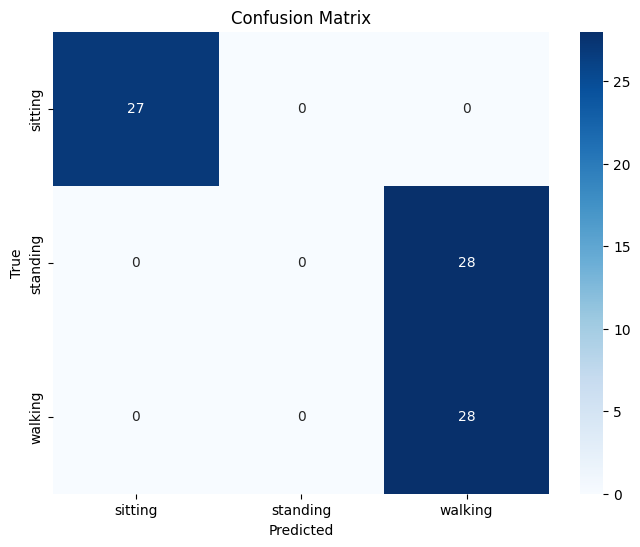

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicted labels: take argmax of probabilities
predicted_labels = np.argmax(predictions_df_videos[['sitting_prob', 'standing_prob', 'walking_prob']].values, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['sitting', 'standing', 'walking'], yticklabels=['sitting', 'standing', 'walking'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Classification report of vision transformer - Test data

In [134]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['sitting', 'standing', 'walking'], zero_division=0)

# Print the classification report
print(report)

              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00        27
    standing       0.00      0.00      0.00        28
     walking       0.50      1.00      0.67        28

    accuracy                           0.66        83
   macro avg       0.50      0.67      0.56        83
weighted avg       0.49      0.66      0.55        83



# Random Forest Model

In [1]:
!pip install --upgrade scikit-learn==1.6.1


In [2]:
import sklearn
print(sklearn.__version__)


1.6.1


Restart Kernal if it doesn't show up!

## Loading model

In [3]:
import joblib

rf_model = joblib.load('/kaggle/input/final-models-of-random-forest-and-transformers/pytorch/default/1/rf_model.joblib')
scaler = joblib.load('/kaggle/input/final-models-of-random-forest-and-transformers/pytorch/default/1/scaler.joblib')

### Functions from training pipeline

In [39]:
import os

def predict_from_test_data(test_data_dir, model, scaler, class_names):
    
    prediction_data = []

    # Iterate over all files in the test data directory
    for file in os.listdir(test_data_dir):
        file_path = os.path.join(test_data_dir, file)
        
        # Read the CSV file containing accelerometer data
        df = pd.read_csv(file_path, header=None, names=["timestamp", "X", "Y", "Z"])
        
        # Extract features from the accelerometer data
        features = extract_accel_features(df).reshape(1, -1)
        
        # Standardize the features using the fitted scaler
        features = scaler.transform(features)
        
        # Predict the class probabilities using the RF model
        prob = model.predict_proba(features).flatten()
        
        # Append the predictions with the file name and class probabilities
        prediction_data.append([file, *prob])  # file name + class probabilities
    
    # Convert the list of predictions into a DataFrame
    predictions_df = pd.DataFrame(prediction_data, columns=["csv_file_name"] + class_names)
    
    return predictions_df

In [40]:
# Feature extraction function

def extract_accel_features(df):
    features = []
    features.append(np.mean(df['X']))
    features.append(np.std(df['X']))
    features.append(np.min(df['X']))
    features.append(np.max(df['X']))
    
    features.append(np.mean(df['Y']))
    features.append(np.std(df['Y']))
    features.append(np.min(df['Y']))
    features.append(np.max(df['Y']))
    
    features.append(np.mean(df['Z']))
    features.append(np.std(df['Z']))
    features.append(np.min(df['Z']))
    features.append(np.max(df['Z']))
    
    return np.array(features)

In [41]:
import pandas as pd
import numpy as np


test_data_dir = '/kaggle/input/har-test-dataset/Test_Accelerometer_Data'  
class_names = ['Standing', 'Sitting', 'Walking'] 


csv_predictions_df = predict_from_test_data(test_data_dir, rf_model, scaler, class_names)

# Print the predictions DataFrame
print(csv_predictions_df)


#for file_path, prob in predictions.items():
 #   print(f"Predictions for {file_path}: {prob}")

     csv_file_name  Standing  Sitting  Walking
0    sitting22.csv      0.00     1.00     0.00
1    standing7.csv      0.87     0.00     0.13
2     walking8.csv      0.04     0.01     0.95
3   standing13.csv      0.91     0.00     0.09
4    walking10.csv      0.01     0.00     0.99
..             ...       ...      ...      ...
78    walking2.csv      0.00     0.00     1.00
79  standing25.csv      0.81     0.00     0.19
80    sitting6.csv      0.00     1.00     0.00
81  standing17.csv      0.80     0.01     0.19
82   walking19.csv      0.00     0.01     0.99

[83 rows x 4 columns]


### Classification report for random forest - Test data

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# 1. Get predicted class from probabilities
csv_predictions_df['pred_class'] = csv_predictions_df[['Standing', 'Sitting', 'Walking']].idxmax(axis=1)

# 2. Map class names to numeric labels
class_map = {'Sitting': 0, 'Standing': 1, 'Walking': 2}
csv_predictions_df['pred_label'] = csv_predictions_df['pred_class'].map(class_map)


def extract_label_from_filename(filename):
    if 'sitting' in filename.lower():
        return 0
    elif 'standing' in filename.lower():
        return 1
    elif 'walking' in filename.lower():
        return 2
    else:
        return -1  # unknown

csv_predictions_df['true_label'] = csv_predictions_df['csv_file_name'].apply(extract_label_from_filename)

# 3. Classification report
report = classification_report(csv_predictions_df['true_label'], csv_predictions_df['pred_label'], target_names=['Sitting','Standing','Walking'])
print("Classification Report for Random Forest on Accelerometer Test Data:")
print(report)

Classification Report for Random Forest on Accelerometer Test Data:
              precision    recall  f1-score   support

     Sitting       1.00      1.00      1.00        27
    Standing       1.00      0.96      0.98        28
     Walking       0.97      1.00      0.98        28

    accuracy                           0.99        83
   macro avg       0.99      0.99      0.99        83
weighted avg       0.99      0.99      0.99        83



# Weighted Averaging

In [57]:
# F1 scores of the two models
f1_model_2 = 0.56
f1_model_1 = 0.99

# Calculate the total sum of F1 scores
total_f1 = f1_model_1 + f1_model_2

# Calculate the weights
w_1 = f1_model_1 / total_f1
w_2 = f1_model_2 / total_f1

w_1, w_2


(0.6387096774193548, 0.3612903225806452)

## Loading the predictions

In [58]:
df_model1 = csv_predictions_df
df_model2 = predictions_df_videos

In [61]:
df_model1['csv_file_name'] = df_model1['csv_file_name'].str.replace('.csv', '')
df_model2['video_name'] = df_model2['video_name'].str.replace('.mp4', '')

### Fusing model pred probabilities

In [121]:
# Remove file extensions to align names
df_model1['csv_file_name'] = df_model1['csv_file_name'].str.replace('.csv', '')
df_model2['video_name'] = df_model2['video_name'].str.replace('.mp4', '')

# Merge the two dataframes on the identifiers (csv_file_name / video_name)
merged_df = pd.merge(df_model1, df_model2, left_on='csv_file_name', right_on='video_name')

# Calculate the weighted average for each class (Sitting, Standing, Walking)
merged_df['final_sitting'] = (w_1 * merged_df['Sitting']) + (w_2 * merged_df['sitting_prob'])
merged_df['final_standing'] = (w_1 * merged_df['Standing']) + (w_2 * merged_df['standing_prob'])
merged_df['final_walking'] = (w_1 * merged_df['Walking']) + (w_2 * merged_df['walking_prob'])

# Make the final prediction
merged_df['final_prediction'] = merged_df[['final_sitting', 'final_standing', 'final_walking']].idxmax(axis=1)

# Remove unnecessary columns
final_df = merged_df[['csv_file_name', 'final_sitting', 'final_standing', 'final_walking', 'final_prediction', 'true_label']]

print(final_df)

   csv_file_name  final_sitting  final_standing  final_walking  \
0      sitting22       0.999994        0.000002       0.000003   
1      standing7       0.000038        0.713970       0.285992   
2       walking8       0.006504        0.186655       0.806841   
3     standing13       0.000069        0.755077       0.244855   
4      walking10       0.000059        0.152407       0.847533   
..           ...            ...             ...            ...   
78      walking2       0.000040        0.162492       0.837468   
79    standing25       0.000026        0.661968       0.338006   
80      sitting6       0.999990        0.000003       0.000007   
81    standing17       0.006417        0.663500       0.330083   
82     walking19       0.006426        0.152475       0.841099   

   final_prediction  true_label  
0     final_sitting           0  
1    final_standing           1  
2     final_walking           2  
3    final_standing           1  
4     final_walking           2  
.. 

In [122]:
prediction_map = {
    'final_sitting': 0,
    'final_standing': 1,
    'final_walking': 2
}

final_df.loc[:, 'final_prediction'] = final_df['final_prediction'].map(prediction_map)

## Final Confusion Matrix of Fused Model

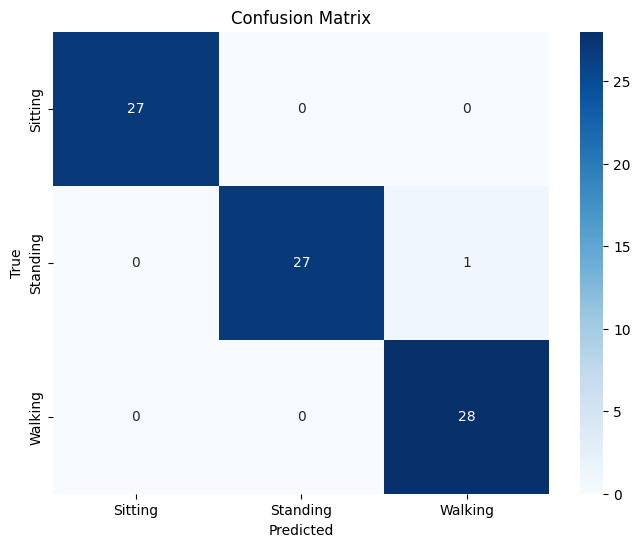

In [123]:

new_final_df = final_df.dropna(subset=['final_prediction', 'true_label'])  
new_final_df['final_prediction'] = new_final_df['final_prediction'].astype(int)
new_final_df['true_label'] = new_final_df['true_label'].astype(int)

# Generate the confusion matrix
cm = confusion_matrix(new_final_df['true_label'], new_final_df['final_prediction'], labels=[0, 1, 2])

# Visualize the confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sitting', 'Standing', 'Walking'], yticklabels=['Sitting', 'Standing', 'Walking'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [83]:
final_df.to_csv('final_df.csv', index=False)

In [63]:
df_model2

,video_name,sitting_prob,standing_prob,walking_prob
0,sitting22,0.999985,0.000006,0.000009
1,sitting6,0.999973,0.000008,0.000020
2,walking2,0.000111,0.449755,0.550134
3,sitting10,0.999709,0.000094,0.000197
4,standing28,0.000181,0.443082,0.556737
...,...,...,...,...
78,standing27,0.027520,0.397646,0.574835
79,standing7,0.000104,0.438132,0.561764
80,walking23,0.000100,0.417788,0.582112
81,sitting3,0.999873,0.000045,0.000082


In [62]:
df_model1

,csv_file_name,Standing,Sitting,Walking,pred_class,pred_label,true_label
0,sitting22,0.00,1.00,0.00,Sitting,0,0
1,standing7,0.87,0.00,0.13,Standing,1,1
2,walking8,0.04,0.01,0.95,Walking,2,2
3,standing13,0.91,0.00,0.09,Standing,1,1
4,walking10,0.01,0.00,0.99,Walking,2,2
...,...,...,...,...,...,...,...
78,walking2,0.00,0.00,1.00,Walking,2,2
79,standing25,0.81,0.00,0.19,Standing,1,1
80,sitting6,0.00,1.00,0.00,Sitting,0,0
81,standing17,0.80,0.01,0.19,Standing,1,1
